In [ ]:
!pip install -U kaggle
import os
os.environ["KAGGLE_API_TOKEN"] = "xxxxxxxxxxxxxxxxxxxx"
!kaggle config set -n api_token -v $KAGGLE_API_TOKEN


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.3/256.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 161.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 24.5 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5
- api_token is now set to: KGAT_01eb6a0a96e82621ee52ba0d75f47f3e


In [ ]:
import os
import zipfile # Import the zipfile module

# Create data dir
DATA_DIR = "/content/data"
os.makedirs(DATA_DIR, exist_ok=True)

from google.colab import drive
drive.mount('/content/drive')


!mkdir -p /content/data
!cp -r /content/drive/MyDrive/GAN_Painter/monet_jpg /content/data/
!cp -r /content/drive/MyDrive/GAN_Painter/photo_jpg /content/data/

# Resulting directories:
MONET_DIR = "/content/data/monet_jpg"
PHOTO_DIR = "/content/data/photo_jpg"

print("Counts:",
      "monet:", len([f for f in os.listdir(MONET_DIR) if f.lower().endswith(".jpg")]),
      "photos:", len([f for f in os.listdir(PHOTO_DIR) if f.lower().endswith(".jpg")]))

Mounted at /content/drive
Counts: monet: 300 photos: 7038


In [ ]:
# Imports
# Loads essential libraries: math, random, numpy, tensorflow, and Keras layers.

# Configuration
# Prints TensorFlow version.
# Defines constants:
# IMG_SIZE = 256: Image resolution.
# BATCH_SIZE = 1: Small batch size (common for CycleGAN).
# BUFFER_SIZE = 1024: Shuffle buffer for dataset.
# EPOCHS = 20: Training epochs (CycleGAN often needs 40–100+).
# LR_G, LR_D = 2e-4: Learning rates for generators and discriminators.
# LAMBDA_CYCLE = 10.0: Weight for cycle-consistency loss.
# LAMBDA_ID = 0.5: Weight for identity loss (usually ≤ 0.5 × cycle weight).

# InstanceNormalization Layer
# Why? CycleGAN uses Instance Normalization instead of BatchNorm because batch size is very small.
# What it does:
# Computes per-instance mean and variance across spatial dimensions.
# Normalizes each channel independently.
# Applies learnable scale (gamma) and shift (beta).

# Implementation details:
# build(): Creates trainable weights for each channel.
# call(): Normalizes input using tf.nn.moments and applies affine transform.

import math, random, glob, time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow", tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

IMG_SIZE = 256
BATCH_SIZE = 1         # CycleGAN often uses small batch sizes
BUFFER_SIZE = 1024
EPOCHS = 20            # try 40–100 for stronger results if you have time
LR_G = 2e-4
LR_D = 2e-4
LAMBDA_CYCLE = 10.0    # cycle consistency weight
LAMBDA_ID = 0.5        # identity loss weight (<= 0.5 * LAMBDA_CYCLE is common)

# Lightweight InstanceNorm to avoid tf-addons dependency
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        dim = input_shape[-1]
        self.gamma = self.add_weight(shape=(dim,),
                                     initializer="ones",
                                     trainable=True, name="gamma")
        self.beta  = self.add_weight(shape=(dim,),
                                     initializer="zeros",
                                     trainable=True, name="beta")

    def call(self, x):
        mean, var = tf.nn.moments(x, axes=[1,2], keepdims=True)
        x_norm = (x - mean) / tf.sqrt(var + self.epsilon)
        return self.gamma * x_norm + self.beta



TensorFlow 2.18.0


In [ ]:
# load_image(path)
# Reads an image file from disk.
# Decodes JPEG into a tensor with 3 channels (RGB).
# Resizes to IMG_SIZE × IMG_SIZE (e.g., 256×256).
# Converts to float32 and normalizes pixel values to [-1, 1] (common for GANs).

# make_ds(folder)
# Creates a tf.data.Dataset from all files in the given folder.
# Maps each file path to an image using load_image.
# Applies:
# Shuffle: Randomizes order with buffer size BUFFER_SIZE.
# Repeat: Makes dataset infinite (for continuous training).
# Batch: Groups images into batches of size BATCH_SIZE (here, 1).
# Prefetch: Improves performance by overlapping data loading with model execution.

# Domain-specific datasets
# monet_ds and photo_ds represent two unpaired domains (Monet paintings vs Photos).
# Each yields batches of shape (BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3).

# Sampling
# Creates iterators (iter(monet_ds) and iter(photo_ds)).
# Fetches one batch from each (next(...)).
# Expected shape: (1, 256, 256, 3) for both samples.

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method="bilinear")
    img = tf.cast(img, tf.float32)
    img = (img / 127.5) - 1.0   # [-1, 1]
    return img

def make_ds(folder):
    files = tf.data.Dataset.list_files(tf.strings.join([folder, "/*"]), shuffle=True)
    ds = files.map(load_image, num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

monet_ds = make_ds(MONET_DIR)
photo_ds = make_ds(PHOTO_DIR)

monet_iter = iter(monet_ds)
photo_iter = iter(photo_ds)

sample_monet = next(monet_iter)
sample_photo = next(photo_iter)
sample_monet.shape, sample_photo.shape


(TensorShape([1, 256, 256, 3]), TensorShape([1, 256, 256, 3]))

In [ ]:
# Purpose
# Build the CycleGAN components for unpaired image-to-image translation (Photos ↔ Monets), including:
# Two UNet-style generators (G_AB, G_BA)
# Two PatchGAN discriminators (D_A, D_B)
# A custom InstanceNormalization layer (used throughout the generators)

# Core Building Blocks
# InstanceNormalization: Normalizes each image per channel across spatial dimensions; includes learnable gamma (scale) and beta (shift). Ideal for batch size = 1 and style transfer tasks.
# downsample(x, filters): 3×3 strided conv (stride=2) + InstanceNorm + ReLU; halves spatial size, increases channels.
# upsample(x, filters): 3×3 transposed conv (stride=2) + InstanceNorm + ReLU; doubles spatial size, adjusts channels.

# Generator (UNet-style)
# Function: build_generator(name="G")
# Flow (for 256×256 input):
# Encoder path:
#   Conv 7×7 → 64 + InstanceNorm + ReLU
#   Downsample ×4: 256→128→64→32→16 (filters: 128, 256, 512, 512)
# Bottleneck:
#   Conv layers at 16×16 with 512 filters
# Decoder path (with skip connections):
#   Upsample ×4: 16→32→64→128→256 (filters: 512, 256, 128, 64)
#   Skip connections from encoder to decoder at each level
# Final Conv 7×7 → 3 + InstanceNorm
# Output tanh: image in [-1, 1]

# Roles:
# Encodes input, transforms via bottleneck, and decodes with skip connections to preserve fine details.

# Discriminator (PatchGAN)
# Function: build_discriminator(name="D")
# Flow:
# Stack of 4×4 Conv2D layers with LeakyReLU(0.2):
# Strides: 2, 2, 2, then 1 (filters: 64, 128, 256, 512)
# Final Conv2D(1, 4) → patch-wise logits (grid of real/fake scores)

# Roles:
# Evaluates local realism (textures/edges) instead of whole-image classification, stabilizing training and capturing fine details.

# Domain Setup
# G_AB: Photo → Monet
# G_BA: Monet → Photo
# D_A: Discriminator for Photos
# D_B: Discriminator for Monets
# This matches the standard CycleGAN design with two generators + two discriminators.

# Parameter Count
# The snippet sums all trainable parameters across G_AB, G_BA, D_A, and D_B and prints the total for a quick capacity check.


def downsample(x, filters):
    x = layers.Conv2D(filters, 3, strides=2, padding="same")(x)
    x = InstanceNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def upsample(x, filters):
    x = layers.Conv2DTranspose(filters, 3, strides=2, padding="same")(x)
    x = InstanceNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def build_generator(name="G"):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Encoder path
    # Initial conv
    e1 = layers.Conv2D(64, 7, padding="same")(inputs)
    e1 = InstanceNormalization()(e1)
    e1 = layers.Activation("relu")(e1)
    
    # Downsampling layers
    e2 = downsample(e1, 128)  # 128x128, 128 channels
    e3 = downsample(e2, 256)  # 64x64, 256 channels
    e4 = downsample(e3, 512)  # 32x32, 512 channels
    e5 = downsample(e4, 512)  # 16x16, 512 channels
    
    # Bottleneck
    b = layers.Conv2D(512, 3, padding="same")(e5)
    b = InstanceNormalization()(b)
    b = layers.Activation("relu")(b)
    b = layers.Conv2D(512, 3, padding="same")(b)
    b = InstanceNormalization()(b)
    b = layers.Activation("relu")(b)
    
    # Decoder path with skip connections
    # After upsample and concatenation, reduce channels with conv
    d1 = upsample(b, 512)  # 32x32, 512 channels
    d1 = layers.Concatenate()([d1, e4])  # 32x32, 1024 channels (512+512)
    d1 = layers.Conv2D(512, 3, padding="same")(d1)  # Reduce to 512
    d1 = InstanceNormalization()(d1)
    d1 = layers.Activation("relu")(d1)
    
    d2 = upsample(d1, 256)  # 64x64, 256 channels
    d2 = layers.Concatenate()([d2, e3])  # 64x64, 512 channels (256+256)
    d2 = layers.Conv2D(256, 3, padding="same")(d2)  # Reduce to 256
    d2 = InstanceNormalization()(d2)
    d2 = layers.Activation("relu")(d2)
    
    d3 = upsample(d2, 128)  # 128x128, 128 channels
    d3 = layers.Concatenate()([d3, e2])  # 128x128, 256 channels (128+128)
    d3 = layers.Conv2D(128, 3, padding="same")(d3)  # Reduce to 128
    d3 = InstanceNormalization()(d3)
    d3 = layers.Activation("relu")(d3)
    
    d4 = upsample(d3, 64)  # 256x256, 64 channels
    d4 = layers.Concatenate()([d4, e1])  # 256x256, 128 channels (64+64)
    d4 = layers.Conv2D(64, 3, padding="same")(d4)  # Reduce to 64
    d4 = InstanceNormalization()(d4)
    d4 = layers.Activation("relu")(d4)
    
    # Final output layer
    outputs = layers.Conv2D(3, 7, padding="same")(d4)
    outputs = InstanceNormalization()(outputs)
    outputs = layers.Activation("tanh")(outputs)
    
    return keras.Model(inputs, outputs, name=name)

def build_discriminator(name="D"):
    def disc_layer(x, filters, stride=2):
        x = layers.Conv2D(filters, 4, strides=stride, padding="same")(x)
        x = layers.LeakyReLU(0.2)(x)
        return x

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = disc_layer(inputs, 64, stride=2)
    x = disc_layer(x, 128, stride=2)
    x = disc_layer(x, 256, stride=2)
    x = disc_layer(x, 512, stride=1)
    x = layers.Conv2D(1, 4, strides=1, padding="same")(x)   # PatchGAN logits
    return keras.Model(inputs, x, name=name)

# Domain A: Photos, Domain B: Monets
G_AB = build_generator("G_AB")  # Photo -> Monet
G_BA = build_generator("G_BA")  # Monet -> Photo
D_A  = build_discriminator("D_A")
D_B  = build_discriminator("D_B")

sum_model_params = sum([np.sum([np.prod(v.shape) for v in m.trainable_variables]) for m in [G_AB,G_BA,D_A,D_B]])
print("Total trainable params:", sum_model_params)


Total trainable params: 28306836


In [ ]:
# GAN loss (LSGAN style is common in CycleGAN; we'll use standard BCE on logits)
# To use LSGAN: replace BCE with MSE to targets 1/0.

# BCE adversarial losses are defined for:

# Discriminators (gan_loss): real→1, fake→0.
# Generators (generator_gan_loss): fake→1 (fool the discriminator).

# Cycle-consistency loss (L1) ensures round-trip mapping returns the original image (A→B→A, B→A→B).
# Identity loss (L1) discourages unnecessary changes when input is already in the target domain.
# Optimizers: Adam (LR = 2e-4 typical) with β₁=0.5, β₂=0.999 for stability in GAN training.
# LSGAN alternative: swap BCE with MSE to targets 1/0—commonly used in CycleGAN for smoother gradients.

bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def gan_loss(real_logits, fake_logits):
    real = bce(tf.ones_like(real_logits), real_logits)
    fake = bce(tf.zeros_like(fake_logits), fake_logits)
    return real + fake

def generator_gan_loss(fake_logits):
    return bce(tf.ones_like(fake_logits), fake_logits)

def cycle_consistency_loss(real_x, cycled_x):
    return tf.reduce_mean(tf.abs(real_x - cycled_x))

def identity_loss(real_x, same_x):
    return tf.reduce_mean(tf.abs(real_x - same_x))

opt_G_AB = tf.keras.optimizers.Adam(LR_G, beta_1=0.5, beta_2=0.999)
opt_G_BA = tf.keras.optimizers.Adam(LR_G, beta_1=0.5, beta_2=0.999)
opt_D_A  = tf.keras.optimizers.Adam(LR_D, beta_1=0.5, beta_2=0.999)
opt_D_B  = tf.keras.optimizers.Adam(LR_D, beta_1=0.5, beta_2=0.999)


In [ ]:
# train_step:
# 1) Translate: A->B (fake_monet), B->A (fake_photo)
# 2) Cycle: A->B->A (cycled_photo), B->A->B (cycled_monet)
# 3) Identity: G_AB(y)≈y, G_BA(x)≈x to preserve color/content
# 4) Discriminators: logits for real and fake samples in each domain
# 5) Generator losses:
#    - adversarial (fakes should look real)
#    - cycle-consistency (round-trip reconstruction)
#    - identity (no change on target-domain inputs)
# 6) Discriminator losses:
#    - real→1, fake→0 (PatchGAN logits)
# 7) Backprop: compute gradients per model and apply with Adam
#
# Training loop:
# - steps_per_epoch = min(size(A), size(B)) // batch
# - iterate batches from both domains (datasets repeat infinitely)
# - call train_step and log losses periodically


@tf.function
def train_step(batch_photo, batch_monet):
    # Translate
    fake_monet = G_AB(batch_photo, training=True)
    fake_photo = G_BA(batch_monet, training=True)

    # Cycle
    cycled_photo = G_BA(fake_monet, training=True)
    cycled_monet = G_AB(fake_photo, training=True)

    # Identity
    same_monet = G_AB(batch_monet, training=True)
    same_photo = G_BA(batch_photo, training=True)

    # Discriminator logits
    disc_real_A = D_A(batch_photo, training=True)
    disc_real_B = D_B(batch_monet, training=True)
    disc_fake_A = D_A(fake_photo, training=True)
    disc_fake_B = D_B(fake_monet, training=True)

    # Losses: generators
    loss_G_AB_adv = generator_gan_loss(disc_fake_B)
    loss_G_BA_adv = generator_gan_loss(disc_fake_A)

    loss_cycle_A = cycle_consistency_loss(batch_photo, cycled_photo)
    loss_cycle_B = cycle_consistency_loss(batch_monet, cycled_monet)

    loss_id_A = identity_loss(batch_photo, same_photo)
    loss_id_B = identity_loss(batch_monet, same_monet)

    loss_G_AB = (loss_G_AB_adv
                 + LAMBDA_CYCLE * (loss_cycle_B)
                 + LAMBDA_ID    * (loss_id_B))
    loss_G_BA = (loss_G_BA_adv
                 + LAMBDA_CYCLE * (loss_cycle_A)
                 + LAMBDA_ID    * (loss_id_A))

    # Losses: discriminators
    loss_D_A = gan_loss(disc_real_A, disc_fake_A)
    loss_D_B = gan_loss(disc_real_B, disc_fake_B)

    # Backprop
    grads_G_AB = tf.gradients(loss_G_AB, G_AB.trainable_variables)
    grads_G_BA = tf.gradients(loss_G_BA, G_BA.trainable_variables)
    grads_D_A  = tf.gradients(loss_D_A,  D_A.trainable_variables)
    grads_D_B  = tf.gradients(loss_D_B,  D_B.trainable_variables)

    opt_G_AB.apply_gradients(zip(grads_G_AB, G_AB.trainable_variables))
    opt_G_BA.apply_gradients(zip(grads_G_BA, G_BA.trainable_variables))
    opt_D_A.apply_gradients(zip(grads_D_A,  D_A.trainable_variables))
    opt_D_B.apply_gradients(zip(grads_D_B,  D_B.trainable_variables))

    return {
        "loss_G_AB": loss_G_AB,
        "loss_G_BA": loss_G_BA,
        "loss_D_A":  loss_D_A,
        "loss_D_B":  loss_D_B
    }

# Training loop
steps_per_epoch = min(
    len([f for f in os.listdir(PHOTO_DIR) if f.endswith(".jpg")]),
    len([f for f in os.listdir(MONET_DIR) if f.endswith(".jpg")])
) // BATCH_SIZE

photo_it = iter(photo_ds)
monet_it = iter(monet_ds)

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    log_every = max(1, steps_per_epoch // 10)

    for step in range(1, steps_per_epoch+1):
        batch_photo = next(photo_it)
        batch_monet = next(monet_it)
        metrics = train_step(batch_photo, batch_monet)

        if step % log_every == 0:
            print(f"Epoch {epoch} [{step}/{steps_per_epoch}] "
                  f"G_AB:{metrics['loss_G_AB']:.3f} "
                  f"G_BA:{metrics['loss_G_BA']:.3f} "
                  f"D_A:{metrics['loss_D_A']:.3f} "
                  f"D_B:{metrics['loss_D_B']:.3f}")

    print(f"Epoch {epoch} done in {(time.time()-t0)/60:.1f} min")


Epoch 1 [30/300] G_AB:3.922 G_BA:4.389 D_A:1.271 D_B:1.244
Epoch 1 [60/300] G_AB:3.877 G_BA:3.878 D_A:1.384 D_B:1.316
Epoch 1 [90/300] G_AB:4.287 G_BA:10.715 D_A:2.305 D_B:1.297
Epoch 1 [120/300] G_AB:2.840 G_BA:3.659 D_A:1.176 D_B:1.346
Epoch 1 [150/300] G_AB:3.061 G_BA:7.790 D_A:1.004 D_B:1.258
Epoch 1 [180/300] G_AB:3.390 G_BA:5.140 D_A:1.181 D_B:1.538
Epoch 1 [210/300] G_AB:4.708 G_BA:3.604 D_A:1.140 D_B:1.091
Epoch 1 [240/300] G_AB:4.668 G_BA:4.586 D_A:1.375 D_B:1.174
Epoch 1 [270/300] G_AB:3.060 G_BA:3.947 D_A:1.108 D_B:1.420
Epoch 1 [300/300] G_AB:3.213 G_BA:3.845 D_A:1.390 D_B:1.130
Epoch 1 done in 1.6 min
Epoch 2 [30/300] G_AB:3.383 G_BA:3.888 D_A:1.474 D_B:1.072
Epoch 2 [60/300] G_AB:3.013 G_BA:3.483 D_A:1.839 D_B:1.256
Epoch 2 [90/300] G_AB:4.642 G_BA:2.778 D_A:1.097 D_B:0.985
Epoch 2 [120/300] G_AB:3.012 G_BA:3.705 D_A:1.403 D_B:1.285
Epoch 2 [150/300] G_AB:3.339 G_BA:3.270 D_A:1.041 D_B:0.917
Epoch 2 [180/300] G_AB:6.234 G_BA:4.449 D_A:1.166 D_B:1.853
Epoch 2 [210/300] G_A

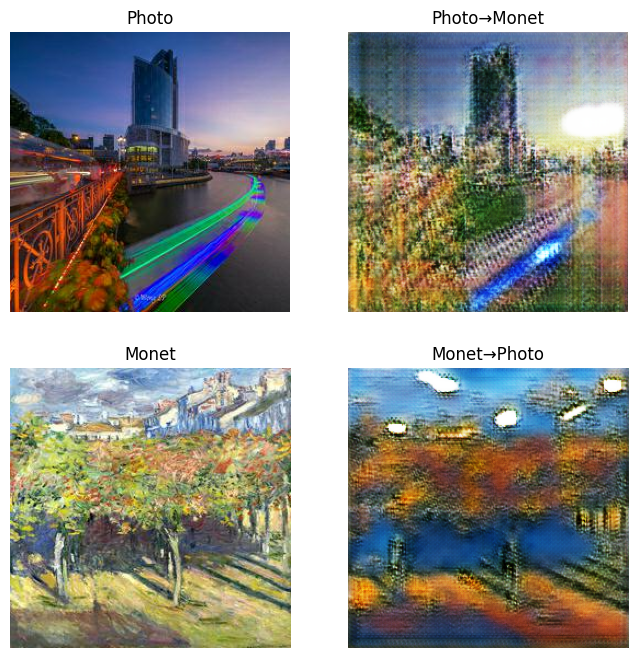

In [ ]:
# denorm(x): Converts tensors from [-1, 1] to uint8 [0, 255] for display.
# show_translation():

# Fetches one photo batch and one Monet batch from their datasets.
# Uses G_AB and G_BA to synthesize Photo→Monet and Monet→Photo translations.
# Extracts the single images from the batches (index [0]).
# Plots a 2×2 grid: original photo, translated Monet; original Monet, translated photo.

# show_translation() call: Triggers the full pipeline to produce a visual sanity check of your trained CycleGAN translations.

import matplotlib.pyplot as plt

def denorm(x):
    x = (x + 1.0) * 127.5
    return tf.cast(tf.clip_by_value(x, 0, 255), tf.uint8)

def show_translation():
    p = next(iter(photo_ds.take(1)))
    m = next(iter(monet_ds.take(1)))
    fake_m = G_AB(p, training=False)
    fake_p = G_BA(m, training=False)

    imgs = [p[0], fake_m[0], m[0], fake_p[0]]
    titles = ["Photo", "Photo→Monet", "Monet", "Monet→Photo"]

    plt.figure(figsize=(8,8))
    for i, (img, title) in enumerate(zip(imgs, titles)):
        plt.subplot(2,2,i+1)
        plt.imshow(denorm(img))
        plt.axis("off")
        plt.title(title)
    plt.show()

show_translation()


In [ ]:
# Goal: Run your trained Photo→Monet generator over 7,000 photos, save the outputs to disk, and package them into a ZIP for submission.
# Steps:
# Build the output folder and collect photo paths (first 7,000).
# Define helpers to load/normalize inputs and de-normalize outputs.
# Loop through photos:
# Load and batch each photo.
# Generate Monet-style image via G_AB.
# Convert to uint8 and save as high-quality JPEG.
# Sanity-check: verify file count and image size.
# Zip all images into /content/images.zip with flat filenames.
# Output: A folder /content/submission_images containing 0.jpg … 6999.jpg and a ZIP file /content/images.zip.

import os, glob, io, zipfile, math
from PIL import Image
import numpy as np
from tqdm import tqdm
import tensorflow as tf

OUTPUT_DIR = "/content/submission_images"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Collect photo files; we need 7,000–10,000 outputs. We'll make 7,000 from photos.
photo_paths = sorted([p for p in glob.glob(f"{PHOTO_DIR}/*.jpg")])
N_SUBMIT = 7000
photo_paths = photo_paths[:N_SUBMIT]

def load_photo_for_inference(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method="bilinear")
    img = tf.cast(img, tf.float32)
    return (img / 127.5) - 1.0  # [-1, 1]

def to_uint8(image_tensor):
    x = (image_tensor + 1.0) * 127.5
    x = tf.clip_by_value(x, 0, 255)
    x = tf.cast(x, tf.uint8)
    return x.numpy()

# Batch inference helper (optional; here BATCH_SIZE=1 so we keep it simple)
for i, p in enumerate(tqdm(photo_paths, desc="Generating Monet-style images")):
    photo = load_photo_for_inference(p)[None, ...]   # shape (1, 256,256,3)
    monet = G_AB(photo, training=False)
    monet_uint8 = to_uint8(monet[0])  # (256,256,3), uint8

    im = Image.fromarray(monet_uint8, mode="RGB")
    out_path = os.path.join(OUTPUT_DIR, f"{i}.jpg")
    im.save(out_path, format="JPEG", quality=95, subsampling=0)

# Sanity check: count and size
saved_files = sorted(glob.glob(f"{OUTPUT_DIR}/*.jpg"))
sizes = [Image.open(saved_files[0]).size if saved_files else None]
print(f"Saved {len(saved_files)} images. Example size: {sizes[0] if sizes else 'N/A'}")
assert len(saved_files) == N_SUBMIT, "Unexpected file count!"
assert Image.open(saved_files[0]).size == (256, 256), "Image size must be 256x256!"

# Zip flat as images.zip (no directory structure)
ZIP_PATH = "/content/images.zip"
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for f in tqdm(saved_files, desc="Zipping"):
        zf.write(f, arcname=os.path.basename(f))

print("Created:", ZIP_PATH, "Size:", os.path.getsize(ZIP_PATH)/1e6, "MB")


Generating Monet-style images: 100%|██████████| 7000/7000 [10:20<00:00, 11.28it/s]


Saved 7000 images. Example size: (256, 256)


Zipping: 100%|██████████| 7000/7000 [00:15<00:00, 455.27it/s]

Created: /content/images.zip Size: 412.008972 MB


In [ ]:

import os

DRIVE_ROOT = "/content/drive/MyDrive/GAN_Painter"
SAVE_DIR = os.path.join(DRIVE_ROOT, "CycleGAN_SavedModels")  # customize this folder name
os.makedirs(SAVE_DIR, exist_ok=True)

print("Saving to:", SAVE_DIR)


Saving to: /content/drive/MyDrive/GAN_Painter/CycleGAN_SavedModels


In [ ]:

# Save full models to Drive
G_AB.save(os.path.join(SAVE_DIR, "G_AB.h5"))  # Photo -> Monet
G_BA.save(os.path.join(SAVE_DIR, "G_BA.h5"))  # Monet -> Photo
D_A.save(os.path.join(SAVE_DIR, "D_A.h5"))
D_B.save(os.path.join(SAVE_DIR, "D_B.h5"))

print("Saved SavedModel directories:",
      [p for p in os.listdir(SAVE_DIR)])


Saved SavedModel directories: ['G_AB.h5', 'G_BA.h5', 'D_A.h5', 'D_B.h5']
